# Import

In [ ]:
from sgp4.api import Satrec
from sgp4.api import SatrecArray
from sgp4.api import jday
from sgp4.api import days2mdhms
from sgp4.conveniences import sat_epoch_datetime

from skyfield.sgp4lib import TEME_to_ITRF
from astropy import coordinates as coord
from astropy import units
from astropy.time import Time 

import datetime

import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import tensorflow as tf

In [ ]:
%matplotlib inline
#%matplotlib qt

# TLE Data

In [ ]:
s = '1 39030U 12073A   20243.50135077 -.00000029  00000-0  30215-5 0  9995'
t = '2 39030  97.9398 129.5645 0000421 359.0790   1.0407 14.72761136412809'

In [ ]:
satellite = Satrec.twoline2rv(s, t)

# Inspect

In [ ]:
print(satellite.epochyr, satellite.epochdays)
print(days2mdhms(satellite.epochyr, satellite.epochdays)) # Epoch date as month, day, hour, minute, seconds

20 243.50135077
(8, 30, 12, 1, 56.706528)


In [ ]:
sat_epoch_datetime(satellite) # Epoch date as month, day, hour, minute, seconds

datetime.datetime(2020, 8, 30, 12, 1, 56, 706527, tzinfo=UTC)

# Predict

In [ ]:
jd, fr = jday(2020, 8, 30, 24, 0, 0)
print(jd, fr)

2459091.5 1.0


In [ ]:
e, r, v = satellite.sgp4(jd, fr)
print(e,r,v)

0 (3049.4024820168297, -2353.2470545607453, 5875.029142653543) (3.669230605144972, -5.229021258050356, -3.990021898951386)


# Read TLE From txt

In [ ]:
def satellite_from_txt(txt_dir):
    firsts = []
    seconds = []

    with open(txt_dir,"r") as openfileobject:
        for line in openfileobject:
            if(line[0] == '1'):
                firsts.append(line.strip())
            else:
                seconds.append(line.strip())

    satellites = []
    for first, second in zip(firsts, seconds):
        satellites.append(Satrec.twoline2rv(first, second))

    satellite_dict = {'Julian Date of Epoch':[],'First time derivative of the mean motion':[],
                      'Ballistic drag coefficient B* in inverse earth radii':[], 'Inclination':[], 'Right ascension of ascending node':[], 'Eccentricity':[], 'Argument of perigee':[], 'Mean anomaly':[], 'Mean motion':[]}

    for satellite in satellites:
        #satellite_dict['Epoch Years'].append(satellite.epochyr)
        #satellite_dict['Epoch Days'].append(satellite.epochdays)
        satellite_dict['Julian Date of Epoch'].append(satellite.jdsatepoch+satellite.jdsatepochF)
        satellite_dict['First time derivative of the mean motion'].append(satellite.ndot)
        #satellite_dict['Second time derivative of the mean motion'].append(satellite.nddot)
        satellite_dict['Ballistic drag coefficient B* in inverse earth radii'].append(satellite.bstar)
        satellite_dict['Eccentricity'].append(satellite.ecco)
        satellite_dict['Mean motion'].append(satellite.no_kozai)
        satellite_dict['Inclination'].append(satellite.inclo*180/np.pi)
        satellite_dict['Right ascension of ascending node'].append(satellite.nodeo*180/np.pi)
        satellite_dict['Argument of perigee'].append(satellite.argpo*180/np.pi)
        satellite_dict['Mean anomaly'].append(satellite.mo*180/np.pi)
    satellite_dict['First time derivative of the mean motion']  = savgol_filter(satellite_dict['First time derivative of the mean motion'], 201, 2)
    satellite_dict['Ballistic drag coefficient B* in inverse earth radii']  = savgol_filter(satellite_dict['Ballistic drag coefficient B* in inverse earth radii'], 201, 2)
    satellite_dict['Eccentricity']  = savgol_filter(satellite_dict['Eccentricity'], 101, 2)
    satellite_dict['Julian Date of Epoch - First Day'] = np.array(satellite_dict['Julian Date of Epoch'])- satellite_dict['Julian Date of Epoch'][0]
    return satellites, satellite_dict, firsts, seconds

# Plot

In [ ]:
def plot_satellite_parameters(satellite_dict, satellite_dict2 = None, n = None):
    fig,axes =  plt.subplots(3,3, figsize=(20, 10))
    keys = ['Julian Date of Epoch', 'First time derivative of the mean motion', 'Ballistic drag coefficient B* in inverse earth radii',
           'Right ascension of ascending node', 'Argument of perigee', 'Mean anomaly', 'Mean motion', 'Inclination', 'Eccentricity']
    values = []
    for key in keys:
        values.append(satellite_dict[key])
    
    for (parameter_name, parameter_values, ax) in zip(keys, values, axes.flatten()):
        ax.plot(satellite_dict['Julian Date of Epoch - First Day'], parameter_values, label = 'Satellite TLE Data')
        if satellite_dict2 is not None:
            ax.plot(satellite_dict2['Julian Date of Epoch - First Day'], satellite_dict2[parameter_name], label = str(n) + '/' + str(len(satellite_dict['Julian Date of Epoch - First Day'])) + ' Datapoints used')
        ax.set_title(parameter_name)
        ax.legend()
    plt.tight_layout()

# RASAT

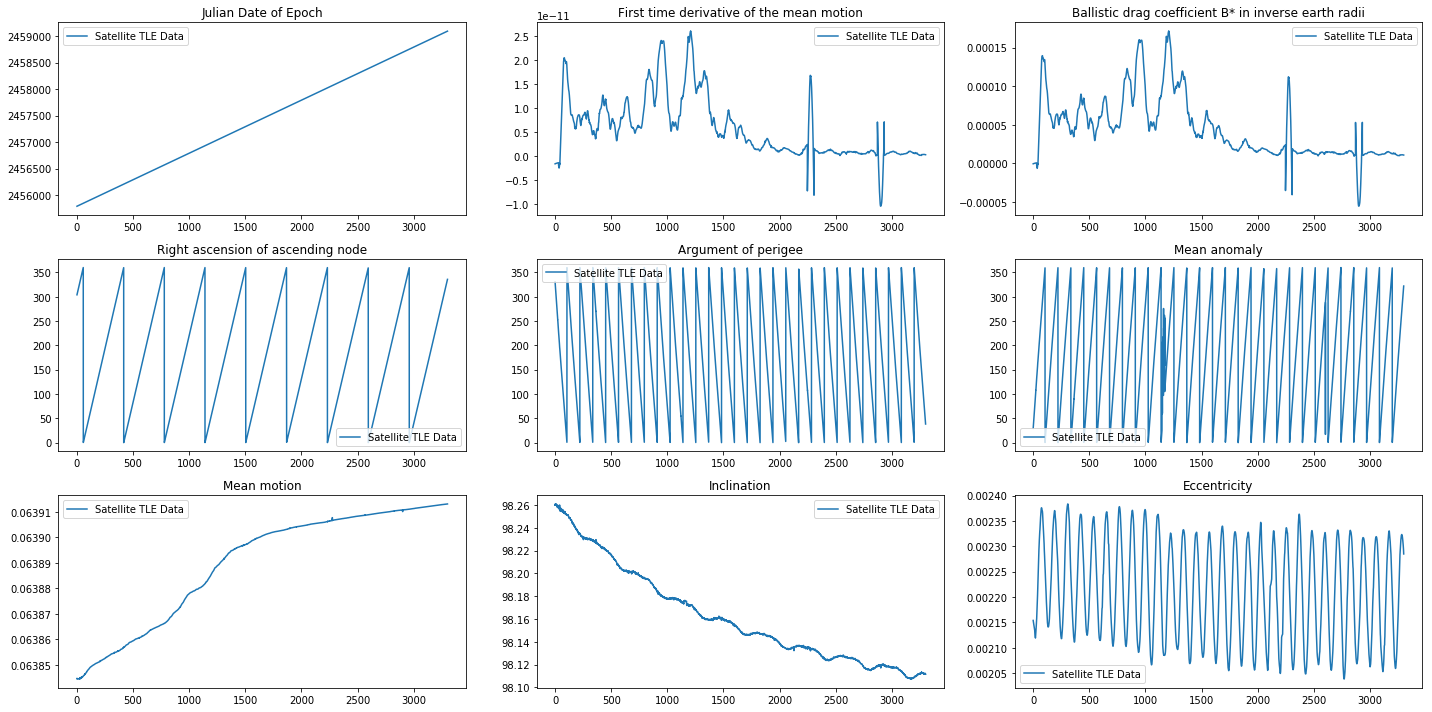

In [ ]:
RASAT_sats, RASAT_dict, RASAT_firsts, RASAT_seconds = satellite_from_txt("RASAT.txt")
plot_satellite_parameters(RASAT_dict)

# GOKTURK-2

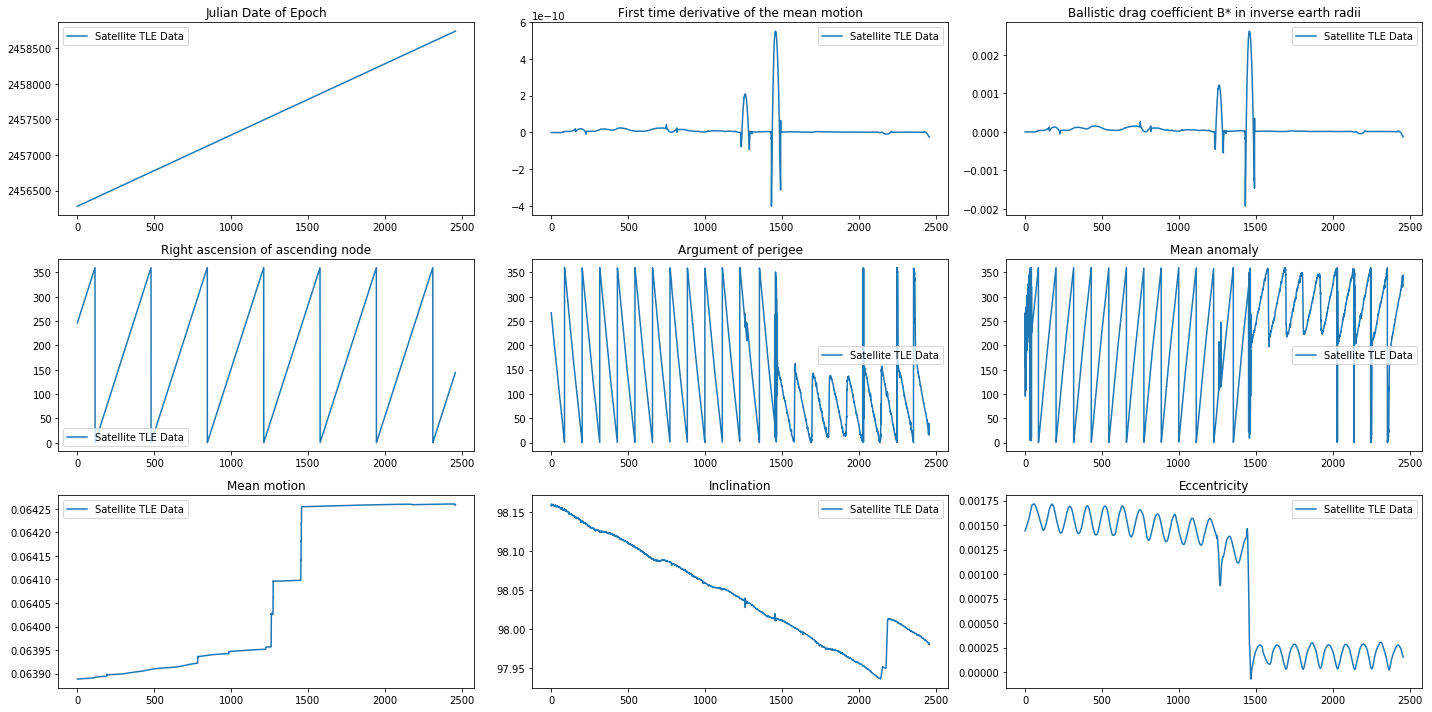

In [ ]:
GOKTURK_2_sats, GOKTURK_2_dict, GOKTURK_2_firsts, GOKTURK_2_seconds = satellite_from_txt("GOKTURK-2.txt")
plot_satellite_parameters(GOKTURK_2_dict)

# Plot in 3D

In [ ]:
Time(satellite.jdsatepoch, format = 'jd')

<Time object: scale='utc' format='jd' value=2459091.5>

In [ ]:
def plot_trajectory3d(satellite, data_num = '0'):
    jd = satellite.jdsatepoch
    coordinates = []
    for time in np.linspace(jd, jd + .1, 100):
        _, r, v = satellite.sgp4(time, 0.0)
        r1, v1 = TEME_to_ITRF(time, np.array(r), np.array(v)*24*60*60)
        now = Time(time, format = 'jd')
        
        itrs = coord.ITRS(r1[0]*units.km, r1[1]*units.km, r1[2]*units.km, v1[0]*units.km/units.s, v1[1]*units.km/units.s, v1[2]*units.km/units.s, obstime=now)
        gcrs = itrs.transform_to(coord.GCRS(obstime=now))
        r, v = gcrs.cartesian.xyz.value,gcrs.velocity.d_xyz.value
        coordinates.append(r)
    coordinates = np.array(coordinates)
    ax.plot3D(coordinates[:,0], coordinates[:,1], coordinates[:,2], label=data_num, linewidth=3)
    plt.legend()
    
    # earth
    u = np.linspace(0, np.pi, 20)
    v = np.linspace(0, 2 * np.pi, 20)
    x = np.outer(np.sin(u), np.sin(v))
    y = np.outer(np.sin(u), np.cos(v))
    z = np.outer(np.cos(u), np.ones_like(v))
    R = 6371
    ax.plot_wireframe(R*x, R*y, R*z, color = 'gray', linewidth=.3)
    plt.tight_layout()

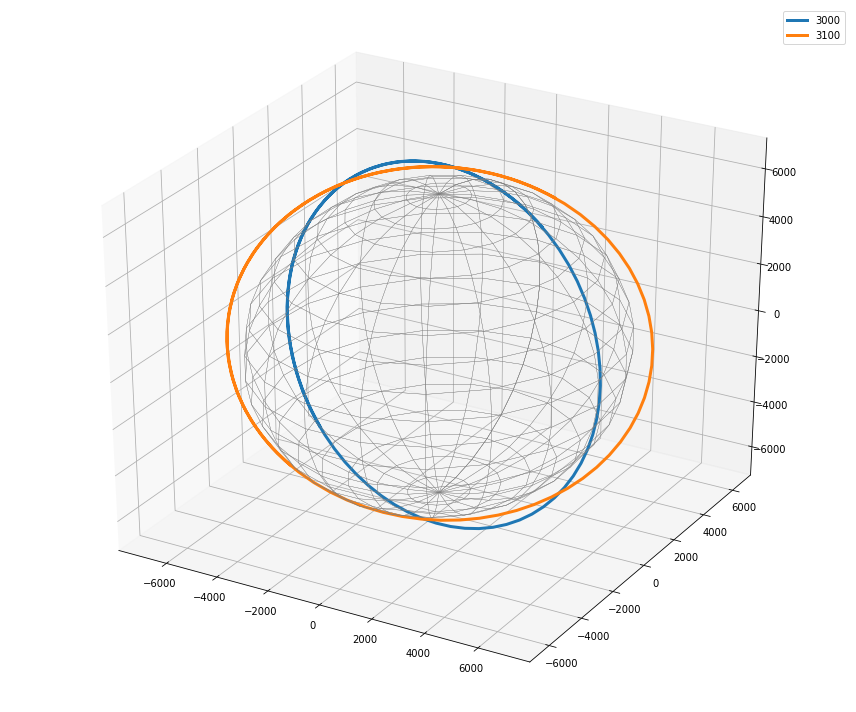

In [ ]:
fig = plt.figure(figsize = (12,10))
ax = plt.axes(projection='3d')
for index in np.linspace(3000, 3100, 2).astype(int):
    plot_trajectory3d(GOKTURK_2_sats[index], str(index))
    #plot_trajectory3d(RASAT_sats[index], str(index))

# FFT

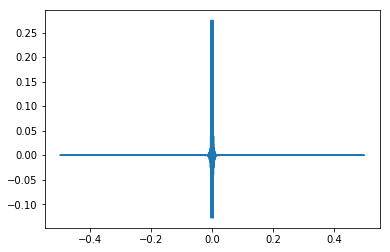

In [ ]:
y = np.array(RASAT_dict['Eccentricity'])
x = np.array(RASAT_dict['Julian Date of Epoch'])
sp = np.fft.fft(y-np.mean(y))
freq = np.fft.fftfreq(x.shape[-1])
plt.plot(freq, sp.real)

# Data Fitting

In [ ]:
class fit:
    def __init__(self, satellite_dict):
        self.satellite_dict = satellite_dict
        
    def linearize_increasing(self, y):
        add = 0
        new_y = [y[0]]
        adds = [0]
        for i, elem in enumerate(y):
            if i<len(y)-1:
                if elem > 355 and y[i+1] < 5:
                    add += 360
                adds.append(add)
                new_y.append(y[i+1]+add)
        return new_y, adds
    
    def linearize_decreasing(self, y):
        add = 0
        new_y = [y[0]]
        adds = [0]
        for i, elem in enumerate(y):
            if i<len(y)-1:
                if elem < 5 and y[i+1] > 5:
                    add += 360
                adds.append(add)
                new_y.append(y[i+1]-add)
        return new_y, adds
    
    def delinearize_increasing(self, fit, adds):
        fit_regular = []
        for add, fit_elem in zip(adds, fit):
            fit_regular.append(fit_elem - add)
        return fit_regular
    
    def delinearize_decreasing(self, fit, adds):
        fit_regular = []
        for add, fit_elem in zip(adds, fit):
            fit_regular.append(fit_elem + add)
        return fit_regular

    def fit_linear(self, y, x, n, increasing = True):
        def linear(x, a, b):
            return a * x + b
        x = np.array(x)
        if increasing:
            new_y, adds = self.linearize_increasing(y)
        else:
            new_y, adds = self.linearize_decreasing(y)
        
        x_fit = x[:n]
        y_fit = new_y[:n]
        
        f = linear
        popt, _ = curve_fit(f, x_fit, y_fit)     
        
        fit = f(x, *popt)
        if increasing:
            fit_regular = self.delinearize_increasing(fit, adds)
        else:
            fit_regular = self.delinearize_decreasing(fit, adds)
        return fit_regular
    
    def fit_eccentricity(self, y, x, n):
        def sin_polynomial(x, a, b, c, d, e, f, g, h, i, j, l):
            return a * np.sin(2*np.pi*2.83e-3 * x + b) + c * np.sin(2*np.pi*2.46e-3 * x + d) +  e * np.sin(2*np.pi*3.13e-3 * x + f) + g * np.sin(2*np.pi*9.45e-5 * x + h) + i * np.sin(2*np.pi*4.63e-3 * x + j)+ l
        x = np.array(x)
        x_fit = x[:n]
        y_fit = y[:n]
        
        f = sin_polynomial
        popt, _ = curve_fit(f, x_fit, y_fit, 
                            bounds=([1e-5, -np.pi, 1e-5, -np.pi, 1e-5, -np.pi, 1e-5, -np.pi, 1e-5, -np.pi, -1], 
                                    [1e-4, np.pi, 1e-4, np.pi, 1e-4, np.pi, 1e-4, np.pi, 1e-4, np.pi, 1]))

        fit = f(x, *popt)
        return fit
    
    def fit_LSTM(self, y, x, n):
        std = np.std(y)
        mean = np.mean(y)
        y_normalized = (y-mean)/std
        x = np.array(x)
       
        y_model = y_normalized[:n:10]
        x_model = x[:n:10]

        y_model = y_model.reshape(y_model.shape + (1,1))
        x_model = x_model.reshape(x_model.shape + (1,1))
        x_full = x.reshape(x.shape + (1,1))

        model = tf.keras.Sequential([

          tf.keras.layers.LSTM(3000, activation='tanh', return_sequences=True),
          tf.keras.layers.Dropout(.2),

          tf.keras.layers.LSTM(2000, activation='tanh', return_sequences=True),
          tf.keras.layers.Dropout(0.2),
            
          tf.keras.layers.LSTM(1000, activation='tanh', return_sequences=True),
          tf.keras.layers.Dropout(0.2),

          tf.keras.layers.LSTM(200, activation='tanh', return_sequences=True),
          tf.keras.layers.Dropout(0.2),

          tf.keras.layers.LSTM(10, activation='tanh', return_sequences=True),
          tf.keras.layers.Dropout(0.2),

          tf.keras.layers.Dense(200, activation='tanh'),
          tf.keras.layers.Dropout(0.2),

          tf.keras.layers.Dense(200, activation='tanh'),
          tf.keras.layers.Dropout(0.2),

          tf.keras.layers.Dense(1)],
        )

        model.compile(loss='mae', optimizer=tf.keras.optimizers.Adamax())
        history = model.fit(x_model,y_model, epochs=150, batch_size=256, verbose = 1)

        fit = (model.predict(x_full)*std+mean)[:,0]
        return fit
    
    def fit_all(self, n):
        satellite_dict_fitted = {'Julian Date of Epoch':[],'First time derivative of the mean motion':[], 
                                 'Ballistic drag coefficient B* in inverse earth radii':[], 'Inclination':[], 
                                 'Right ascension of ascending node':[], 'Eccentricity':[], 
                                 'Argument of perigee':[], 'Mean anomaly':[], 'Mean motion':[]}
        
        satellite_dict_fitted['Julian Date of Epoch'] = self.satellite_dict['Julian Date of Epoch']
        satellite_dict_fitted['Julian Date of Epoch - First Day'] = self.satellite_dict['Julian Date of Epoch - First Day']
        
        # Curve fit
        satellite_dict_fitted['Right ascension of ascending node'] = self.fit_linear(self.satellite_dict['Right ascension of ascending node'], self.satellite_dict['Julian Date of Epoch - First Day'], n)
        satellite_dict_fitted['Argument of perigee'] = self.fit_linear(self.satellite_dict['Argument of perigee'], self.satellite_dict['Julian Date of Epoch - First Day'], n, False)
        satellite_dict_fitted['Mean anomaly'] = self.fit_linear(self.satellite_dict['Mean anomaly'], self.satellite_dict['Julian Date of Epoch - First Day'], n)
        satellite_dict_fitted['Eccentricity'] = self.fit_eccentricity(self.satellite_dict['Eccentricity'], np.arange(len(self.satellite_dict["Eccentricity"])), n)
        
        # LSTM fit
        satellite_dict_fitted['First time derivative of the mean motion'] = self.fit_LSTM(self.satellite_dict['First time derivative of the mean motion'], self.satellite_dict["Julian Date of Epoch - First Day"], n)
        satellite_dict_fitted['Ballistic drag coefficient B* in inverse earth radii'] = self.fit_LSTM(self.satellite_dict['Ballistic drag coefficient B* in inverse earth radii'], self.satellite_dict["Julian Date of Epoch - First Day"], n)
        satellite_dict_fitted['Mean motion'] = self.fit_LSTM(self.satellite_dict['Mean motion'], self.satellite_dict["Julian Date of Epoch - First Day"], n)
        satellite_dict_fitted['Inclination'] = self.fit_LSTM(self.satellite_dict['Inclination'], self.satellite_dict["Julian Date of Epoch - First Day"], n)
        
        return satellite_dict_fitted

In [ ]:
n = 8000
a = fit(RASAT_dict)
RASAT_dict_fitted = a.fit_all(n)

Epoch 1/150
4/4 [==============================] - 3s 830ms/step - loss: 0.7612
Epoch 2/150
4/4 [==============================] - 3s 820ms/step - loss: 0.7380
Epoch 3/150
4/4 [==============================] - 3s 824ms/step - loss: 0.7019
Epoch 4/150
4/4 [==============================] - 3s 822ms/step - loss: 0.7056
Epoch 5/150
4/4 [==============================] - 3s 823ms/step - loss: 0.6065
Epoch 6/150
4/4 [==============================] - 3s 821ms/step - loss: 0.5725
Epoch 7/150
4/4 [==============================] - 3s 827ms/step - loss: 0.5448
Epoch 8/150
4/4 [==============================] - 3s 822ms/step - loss: 0.5391
Epoch 9/150
4/4 [==============================] - 3s 823ms/step - loss: 0.5220
Epoch 10/150
4/4 [==============================] - 3s 823ms/step - loss: 0.5351
Epoch 11/150
4/4 [==============================] - 3s 824ms/step - loss: 0.5143
Epoch 12/150
4/4 [==============================] - 3s 824ms/step - loss: 0.4879
Epoch 13/150
4/4 [===================

4/4 [==============================] - 3s 827ms/step - loss: 0.3997
Epoch 103/150
4/4 [==============================] - 3s 823ms/step - loss: 0.4029
Epoch 104/150
4/4 [==============================] - 3s 823ms/step - loss: 0.4006
Epoch 105/150
4/4 [==============================] - 3s 824ms/step - loss: 0.4035
Epoch 106/150
4/4 [==============================] - 3s 822ms/step - loss: 0.4155
Epoch 107/150
4/4 [==============================] - 3s 821ms/step - loss: 0.4033
Epoch 108/150
4/4 [==============================] - 3s 821ms/step - loss: 0.4125
Epoch 109/150
4/4 [==============================] - 3s 823ms/step - loss: 0.3976
Epoch 110/150
4/4 [==============================] - 3s 817ms/step - loss: 0.3889
Epoch 111/150
4/4 [==============================] - 3s 827ms/step - loss: 0.4068
Epoch 112/150
4/4 [==============================] - 3s 823ms/step - loss: 0.4063
Epoch 113/150
4/4 [==============================] - 3s 819ms/step - loss: 0.4023
Epoch 114/150
4/4 [===========

4/4 [==============================] - 3s 822ms/step - loss: 0.3882
Epoch 53/150
4/4 [==============================] - 3s 822ms/step - loss: 0.4052
Epoch 54/150
4/4 [==============================] - 3s 820ms/step - loss: 0.4079
Epoch 55/150
4/4 [==============================] - 3s 817ms/step - loss: 0.4431
Epoch 56/150
4/4 [==============================] - 3s 820ms/step - loss: 0.4285
Epoch 57/150
4/4 [==============================] - 3s 855ms/step - loss: 0.4029
Epoch 58/150
4/4 [==============================] - 3s 821ms/step - loss: 0.4049
Epoch 59/150
4/4 [==============================] - 3s 826ms/step - loss: 0.4026
Epoch 60/150
4/4 [==============================] - 3s 822ms/step - loss: 0.3980
Epoch 61/150
4/4 [==============================] - 3s 819ms/step - loss: 0.4259
Epoch 62/150
4/4 [==============================] - 3s 823ms/step - loss: 0.4157
Epoch 63/150
4/4 [==============================] - 3s 823ms/step - loss: 0.4015
Epoch 64/150
4/4 [=======================

4/4 [==============================] - 3s 819ms/step - loss: 0.6535
Epoch 3/150
4/4 [==============================] - 3s 812ms/step - loss: 0.3323
Epoch 4/150
4/4 [==============================] - 3s 815ms/step - loss: 0.2296
Epoch 5/150
4/4 [==============================] - 3s 810ms/step - loss: 0.2381
Epoch 6/150
4/4 [==============================] - 3s 814ms/step - loss: 0.1894
Epoch 7/150
4/4 [==============================] - 3s 817ms/step - loss: 0.1860
Epoch 8/150
4/4 [==============================] - 3s 817ms/step - loss: 0.1854
Epoch 9/150
4/4 [==============================] - 3s 817ms/step - loss: 0.1909
Epoch 10/150
4/4 [==============================] - 3s 824ms/step - loss: 0.1855
Epoch 11/150
4/4 [==============================] - 3s 818ms/step - loss: 0.1756
Epoch 12/150
4/4 [==============================] - 3s 823ms/step - loss: 0.1538
Epoch 13/150
4/4 [==============================] - 3s 822ms/step - loss: 0.1568
Epoch 14/150
4/4 [==============================

4/4 [==============================] - 3s 836ms/step - loss: 0.1314
Epoch 104/150
4/4 [==============================] - 3s 829ms/step - loss: 0.1256
Epoch 105/150
4/4 [==============================] - 3s 826ms/step - loss: 0.1362
Epoch 106/150
4/4 [==============================] - 3s 831ms/step - loss: 0.1414
Epoch 107/150
4/4 [==============================] - 3s 826ms/step - loss: 0.1457
Epoch 108/150
4/4 [==============================] - 3s 828ms/step - loss: 0.1431
Epoch 109/150
4/4 [==============================] - 3s 823ms/step - loss: 0.1354
Epoch 110/150
4/4 [==============================] - 3s 828ms/step - loss: 0.1336
Epoch 111/150
4/4 [==============================] - 3s 826ms/step - loss: 0.1449
Epoch 112/150
4/4 [==============================] - 3s 828ms/step - loss: 0.1283
Epoch 113/150
4/4 [==============================] - 3s 825ms/step - loss: 0.1341
Epoch 114/150
4/4 [==============================] - 3s 825ms/step - loss: 0.1371
Epoch 115/150
4/4 [===========

4/4 [==============================] - 3s 827ms/step - loss: 0.1450
Epoch 55/150
4/4 [==============================] - 3s 858ms/step - loss: 0.1404
Epoch 56/150
4/4 [==============================] - 3s 838ms/step - loss: 0.1426
Epoch 57/150
4/4 [==============================] - 3s 831ms/step - loss: 0.1340
Epoch 58/150
4/4 [==============================] - 3s 828ms/step - loss: 0.1372
Epoch 59/150
4/4 [==============================] - 3s 825ms/step - loss: 0.1267
Epoch 60/150
4/4 [==============================] - 3s 830ms/step - loss: 0.1334
Epoch 61/150
4/4 [==============================] - 3s 829ms/step - loss: 0.1327
Epoch 62/150
4/4 [==============================] - 3s 828ms/step - loss: 0.1367
Epoch 63/150
4/4 [==============================] - 3s 826ms/step - loss: 0.1360
Epoch 64/150
4/4 [==============================] - 3s 827ms/step - loss: 0.1550
Epoch 65/150
4/4 [==============================] - 3s 830ms/step - loss: 0.1434
Epoch 66/150
4/4 [=======================

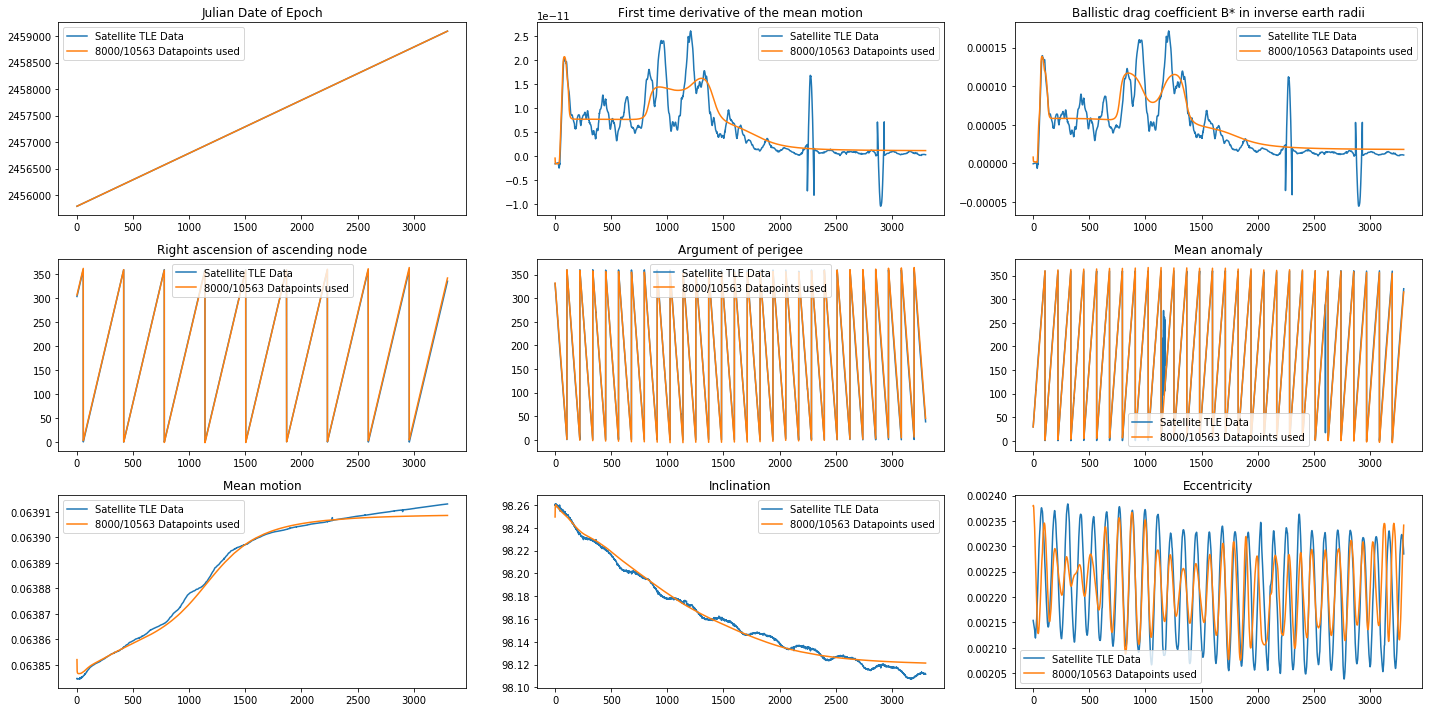

In [ ]:
plot_satellite_parameters(RASAT_dict, RASAT_dict_fitted, n)

# TLE Synthesis

In [ ]:
def TLE_synthesizer(satnum, international_designator, epochyr, epochdays, ndot, nddot, bstar, inclo, nodeo, ecco, argpo, mo, no_kozai):
    line1 = "1 " + str(satnum) + "U " + str(international_designator) + " "
    line1 = line1 + "{:0>2d}".format(epochyr) + "{:.12f}".format(epochdays)[:12] + " "
    line1 = line1 + "{: .11f}".format(ndot)[0]+"{: .11f}".format(ndot)[2:11] + " "
    line1 = line1 + "{: .5e}".format(nddot)[0]+"{: .5e}".format(nddot)[3:-4] + "{: .5e}".format(nddot)[-3] + "{: .5e}".format(nddot)[-1] +  " "

    line1 = line1 + "{: .5e}".format(bstar*10)[0:2]+"{: .5e}".format(bstar*10)[3:7]+"{: .5e}".format(bstar*10)[-3]+"{: .5e}".format(bstar*10)[-1] + " "
    line1 = line1 + "0 " + "0000" # Element set number
    line1 = line1 + "0"
    
    line2 = "2 " + str(satnum) + " "
    line2 = line2 + "{: .7f}".format(inclo)[:8] + " "
    line2 = line2 + "{:.7f}".format(nodeo)[:8] + " "
    line2 = line2 + "{: .7f}".format(ecco)[3:][:7]  + " "
    line2 = line2 + "{:.7f}".format(argpo)[:8] + " "
    line2 = line2 + "{:.7f}".format(mo)[:8] + " "
    line2 = line2 + "{:.11f}".format(no_kozai/2/np.pi*24*60)[:11]
    line2 = line2 + "00000"
    line2 = line2 + "0"
    return line1, line2

# Difference of 2 TLE

In [ ]:
# date as single input jd
def difference_of_TLE(TLE1, TLE2, date):
    satellite1 = Satrec.twoline2rv(TLE1[0], TLE1[1])
    satellite2 = Satrec.twoline2rv(TLE2[0], TLE2[1])
    
    times = np.linspace(jd, jd+1, 100)
    difference = []
    for time in times:
        _, r1, _ = satellite1.sgp4(time, 0.0)
        _, r2, _ = satellite2.sgp4(time, 0.0)
        diff = np.array(r1)-np.array(r2)
        difference.append(np.linalg.norm(diff, ord = 2))
    return np.max(difference)

In [ ]:
rasat1 = ["1 37791U 11044D   20209.06119902  .00000013  00000-0  11478-4 0  9997", "2 37791  98.1132 301.3654 0022721 142.6951 217.5830 14.64775752478044"]
rasat2 = ['1 37791U 11044D   20243.83126096 +.00000023 +00000-0 +13359-4 0  9993', '2 37791 098.1116 335.6450 0022849 038.2872 321.9945 14.64779937483135']

In [ ]:
difference_of_TLE(rasat1, rasat2, 20243.83126096)

3.310336163616673

# Calculate Difference of Generated TLE in KM

In [ ]:
i = 10000

satnum = RASAT_sats[i].satnum
international_designator = '11044D  '
epochyr = RASAT_sats[i].epochyr
epochdays = RASAT_sats[i].epochdays
ndot = RASAT_dict_fitted['First time derivative of the mean motion'][i][0]
nddot = 0
bstar =  RASAT_dict_fitted['Ballistic drag coefficient B* in inverse earth radii'][i][0]
inclo = RASAT_dict_fitted['Inclination'][i][0]
nodeo = RASAT_dict_fitted['Right ascension of ascending node'][i]
ecco = RASAT_dict_fitted['Eccentricity'][i]
argpo = RASAT_dict_fitted['Argument of perigee'][i]
mo = RASAT_dict_fitted['Mean anomaly'][i]
no_kozai = RASAT_dict_fitted['Mean motion'][i][0]

TLE_synthesized = TLE_synthesizer(satnum, international_designator, epochyr, epochdays, ndot, nddot, bstar, 
                                  inclo, nodeo, ecco, argpo, mo, no_kozai)
sat_synth = Satrec.twoline2rv(TLE_synthesized[0], TLE_synthesized[1])

In [ ]:
print(TLE_synthesized[0])
print(RASAT_firsts[i])
print(TLE_synthesized[1])
print(RASAT_seconds[i])

1 37791U 11044D   2097.577729570  .00000000  00000+0  18263-4 0 00000
1 37791U 11044D   20097.57772957 +.00000048 +00000-0 +17958-4 0  9990
2 37791  98.1217 197.2763 0021765 144.8291 215.8937 14.64674474000000
2 37791 098.1082 191.4621 0022828 133.9230 226.3866 14.64760997461720


In [ ]:
# Difference of TLE generated and original TLE in km.
difference_of_TLE(TLE_synthesized, [RASAT_firsts[i], RASAT_seconds[i]], sat_synth.jdsatepoch)

5531.1637706133815